68
25


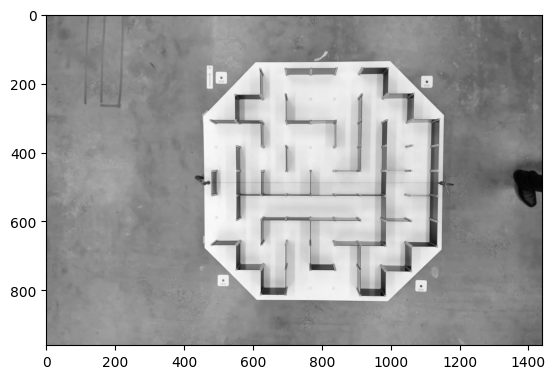

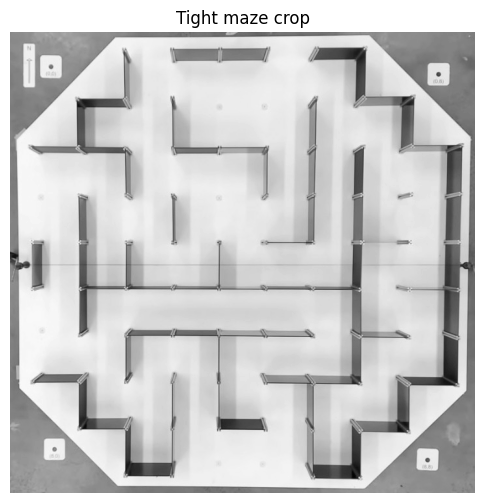

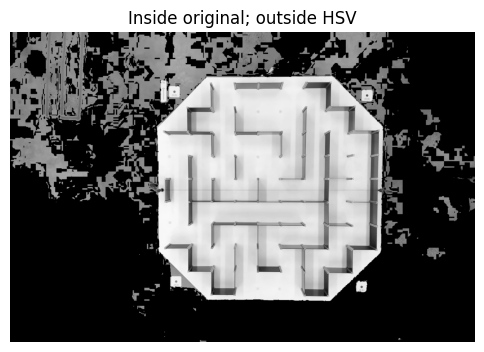

In [114]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

# First Run
# start_row_idx = 8
# start_col_idx = 6
# start_dir = 'S'

# goal_row_idx = 7
# goal_col_idx = 5
# goal_dir = 'N'

# Second run
start_row_idx = 7
start_col_idx = 5
start_dir = 'N'

goal_row_idx = 2
goal_col_idx = 7
goal_dir = 'S'

random.seed(42)
#cv2.imwrite("maze_img0.png", img)
seed = 42
image_file = "RealMaze.png"
threshold_value = 150 # for the occupancy map
autocrop_threshold_value = 145 # for the autocrop adjustment/finetuning
unsafe_kernel_size = 7
unsafe_iterations = 3

# Edge detection parameters
canny_low_threshold = 50
canny_high_threshold = 150
sobel_threshold = 50

# Task 3 - BFS
bfs_n = 9  # Wall grid size (kept for reference)
# bfs_start_node = 36  # Start node (0 to 80 for 9x9 grid)
# bfs_end_node = 61   # End node (0 to 80 for 9x9 grid)

bfs_start_node = start_row_idx * 9 + start_col_idx
bfs_end_node = goal_row_idx * 9 + goal_col_idx

print(bfs_start_node)
print(bfs_end_node)

# Task 4 - PRM and Dijkstra
prm_total_nodes_count = 30
prm_connection_radius = 200
prm_start_node = 20            # Start node using same grid system as BFS (0 to 80 for 9x9 grid)
prm_end_node = 60              # End node using same grid system as BFS (0 to 80 for 9x9 grid)


# Task 5 - RRT
rrt_max_nodes_count = 500
rrt_step_size = 40
rrt_max_connection_length = 200
rrt_start_location = (50,50)
rrt_goal_location = (450,450)

# DO NOT ADD OTHER VARIABLES HERE
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

# Display resulting image
plt.imshow(image, cmap = 'gray')
plt.show()

def _contours(img, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE):
    """Version-agnostic cv2.findContours: always returns the contours list."""
    found = cv2.findContours(img, mode, method)
    return found[0] if len(found) == 2 else found[1]

def _find_big_octagon_contour(img_bgr):
    """Edge/contour search for the big board; prefer ~octagon near image center."""
    H, W = img_bgr.shape[:2]
    g = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    g = cv2.GaussianBlur(g, (5,5), 0)
    edge = cv2.Canny(g, 50, 150)
    edge = cv2.dilate(edge, cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)), 2)

    # ✅ use the helper so it works on OpenCV 3 or 4
    cnts = _contours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return None

    cx0, cy0 = W/2.0, H/2.0
    best, best_score = None, -1e18
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 0.05 * W * H:   # ignore small blobs
            continue

        x, y, w, h = cv2.boundingRect(c)
        ar_pen = abs(np.log(max(w,1) / float(max(h,1))))  # squareness penalty

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        verts = len(approx)

        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
        cx, cy = M["m10"]/M["m00"], M["m01"]/M["m00"]
        d2 = (cx - cx0)*2 + (cy - cy0)*2

        # prefer big, near center, ~8 sides, square-ish bbox
        score = 0.06*area - 0.001*d2 - 6.0*abs(verts - 8) - 8.0*ar_pen
        if score > best_score:
            best_score, best = score, approx

    if best is None:
        cmax = max(cnts, key=cv2.contourArea)
        best = cv2.approxPolyDP(cmax, 0.02 * cv2.arcLength(cmax, True), True)

    return best.reshape(-1, 2).astype(np.int32)

def _white_by_hsv(img_bgr, s_max=120, v_min=85):
    """White/near-white mask using ONLY HSV (low S, high V)."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    S, V = hsv[:,:,1], hsv[:,:,2]
    mask = np.where((S <= s_max) & (V >= v_min), 255, 0).astype(np.uint8)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, 2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  k, 1)
    return mask

def _shrink_until_white(poly_mask, white_mask, target_white=0.65, max_iter=40):
    """Iteratively erode polygon mask until enough HSV-white inside."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    m = poly_mask.copy()
    best, best_ratio = m, 0.0
    for _ in range(max_iter):
        inside = (m==255)
        area = int(inside.sum())
        if area == 0: break
        ratio = float((white_mask[inside]==255).sum()) / area
        if ratio > best_ratio: best_ratio, best = ratio, m.copy()
        if ratio >= target_white: return m
        m = cv2.erode(m, kernel, 1)
    return best

def isMaze(img_bgr,
           hsv_low=(30,0,39), hsv_high=(130,255,255),
           white_s_max=120, white_v_min=85,
           white_target=0.65, max_shrink=40,
           erode_k=9, erode_iter=1, margin_px=8):
    """
    Returns: dict with keys
      'mask'            : final octagon mask (0/255)
      'crop_rect'       : (x1,y1,x2,y2)
      'cropped_gray'    : crop from ORIGINAL grayscale (inside unchanged)
      'composite_gray'  : full image: HSV filtering applied only OUTSIDE the octagon
    """
    H,W = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # 1) initial octagon from edges/contours
    poly = _find_big_octagon_contour(img_bgr)
    if poly is None:
        # nothing found: return passthrough
        return {"mask": np.zeros((H,W), np.uint8), "crop_rect": (0,0,W,H),
                "cropped_gray": gray.copy(),
                "composite_gray": gray.copy()}

    poly_mask = np.zeros((H,W), np.uint8)
    cv2.fillPoly(poly_mask, [poly], 255)

    # 2) HSV-white mask and shrink polygon until white fraction is high
    white_mask = _white_by_hsv(img_bgr, s_max=white_s_max, v_min=white_v_min)
    final_mask = _shrink_until_white(poly_mask, white_mask,
                                     target_white=white_target, max_iter=max_shrink)

    # optional tiny tightening then small outward margin in crop
    if erode_iter > 0:
        final_mask = cv2.erode(final_mask,
                               cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(erode_k,erode_k)),
                               erode_iter)

    ys, xs = np.where(final_mask==255)
    if len(xs)==0:
        x1,y1,x2,y2 = 0,0,W,H
    else:
        x1 = max(0, xs.min()-margin_px);  y1 = max(0, ys.min()-margin_px)
        x2 = min(W, xs.max()+1+margin_px); y2 = min(H, ys.max()+1+margin_px)

    # 3) HSV filter for OUTSIDE only
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    outside_mask = cv2.inRange(hsv, np.array(hsv_low,np.uint8), np.array(hsv_high,np.uint8))
    outside_bgr  = cv2.bitwise_and(img_bgr, img_bgr, mask=outside_mask)

    composite = img_bgr.copy()
    outside = (final_mask==0)
    composite[outside] = outside_bgr[outside]

    return {
        "mask": final_mask,
        "crop_rect": (x1,y1,x2,y2),
        "cropped_gray": gray[y1:y2, x1:x2],
        "composite_gray": cv2.cvtColor(composite, cv2.COLOR_BGR2GRAY)
    }

# 0) Load
img_color = cv2.imread(image_file, cv2.IMREAD_COLOR)
assert img_color is not None

# 1) Your HSV range (outside processing)
H_low, H_high = 30, 130
S_low, S_high = 0, 255
V_low, V_high = 39, 255

out = isMaze(
    img_color,
    hsv_low=(H_low,S_low,V_low),
    hsv_high=(H_high,S_high,V_high),
    white_s_max=120,     # how permissive 'white' is (↑ for strong shadows)
    white_v_min=85,      # min brightness for 'white'
    white_target=0.65,   # raise if you want the polygon to hug the wall more
    max_shrink=40,
    erode_k=9, erode_iter=1, margin_px=8
)

x1,y1,x2,y2 = out["crop_rect"]
cropped      = out["cropped_gray"]
composite    = out["composite_gray"]   # full frame, HSV only outside octagon

# 2) Display
plt.figure(figsize=(6,6)); plt.imshow(cropped, cmap='gray'); plt.axis('off'); plt.title('Tight maze crop'); plt.show()
plt.figure(figsize=(6,6)); plt.imshow(composite, cmap='gray'); plt.axis('off'); plt.title('Inside original; outside HSV'); plt.show()

# keep using ⁠ image ⁠ if your downstream expects it
image = cropped

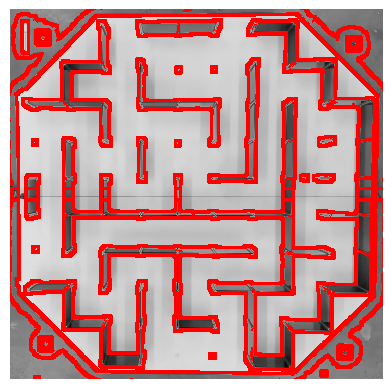

In [115]:
h, w = cropped.shape[:2]
m = min(h, w)

def odd_from_frac(frac: float, base: str = "min", min_px: int = 3) -> int:
    base_len = {"min": min(h, w), "w": w, "h": h}[base]
    k = max(min_px, int(round(frac * base_len)))
    return k if k % 2 else k + 1

# --- tune as FRACTIONS if you like ---
blur_frac  = 0.00005
block_frac = 0.10
C = 15
axis = "min"

k_med    = odd_from_frac(blur_frac,  base=axis)
blockSize = odd_from_frac(block_frac, base=axis)

# 1) Blur + adaptive threshold (creates binary_obstacles)
cropped_blur = cv2.medianBlur(cropped, k_med)
binary_obstacles = cv2.adaptiveThreshold(
    cropped_blur, 255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,
    blockSize, C
)

# 2) HARD IGNORE: erase a centered horizontal band (must be AFTER threshold)
center_strip_frac = 0.04                 # try 0.04–0.08 of image height
half = max(1, int(0.5 * center_strip_frac * h))
y1 = max(0, (h // 2) - half)
y2 = min(h - 1, (h // 2) + half)
binary_obstacles[y1:y2 + 1, :] = 0       # erase the seam band

# 3) Buffer ring (size-aware) + vertical fill across the seam band
margin_frac = 0.010
margin_px   = max(1, int(margin_frac * m))
kernel = np.ones((2 * margin_px + 1, 2 * margin_px + 1), np.uint8)

expanded_obstacles = cv2.dilate(binary_obstacles, kernel, iterations=1)
buffer_zone = cv2.subtract(expanded_obstacles, binary_obstacles)

# Fill the red buffer vertically through the erased band where there's red above/below
k = max(1, int(0.01 * h))  # check window ≈1% of image height

above_band = buffer_zone[max(0, y1 - k):y1, :]
cols_above = (above_band == 255).any(axis=0)

require_below = True  # set to False if you only care about "above"
if require_below:
    below_band = buffer_zone[y2+1:min(h, y2+1 + k), :]
    cols_below = (below_band == 255).any(axis=0)
    cols_to_fill = np.where(cols_above & cols_below)[0]
else:
    cols_to_fill = np.where(cols_above)[0]

if cols_to_fill.size:
    buffer_zone[y1:y2+1, cols_to_fill] = 255

# 4) Visualize
colour_image = cv2.cvtColor(cropped, cv2.COLOR_GRAY2RGB)
colour_image[buffer_zone == 255] = [255, 0, 0]
plt.imshow(colour_image, interpolation='nearest'); plt.axis('off'); plt.show()

In [116]:
# Task 2.1 (0 marks):  Complete the graph class

class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y
    
    def get_point(self):
        return (self.x,self.y)
    
    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = Node(node_id, x, y)
        self.edges[node_id] = []

    def add_edge(self, node_id1, node_id2, weight):
        self.edges[node_id1].append((node_id2, weight))
        self.edges[node_id2].append((node_id1, weight))

    def remove_edge(self, node_id1, node_id2):
        for i in self.edges[node_id1]:
            if i[0] == node_id2:
                index1 = i;
        for i in self.edges[node_id2]:
            if i[0] == node_id1:
                index2 = i;
                
        self.edges[node_id1].remove(index1)
        self.edges[node_id2].remove(index2)
    
    def get_nodes(self):
        return self.nodes
    
    def get_edges(self):
        return self.edges
    
    def get_edge_weight(self, node_id1, node_id2):
        for i in self.edges[node_id1]:
            if i[0] == node_id2:
                return i[1]

In [117]:
# This is a useful function that you may choose to implement and use 
# It looks through the image to see if the path is clear between one coordinate to the next
# Returns True or False 
def path_clear(image, x1, y1, x2, y2):

    ROI = image[y1:y2, x1:x2]
    
    for i in ROI:
        for j in i:
            if (j == [255, 0, 0]).all() or (j == [0, 0, 0]).all():
                return False
    
    return True

710
710


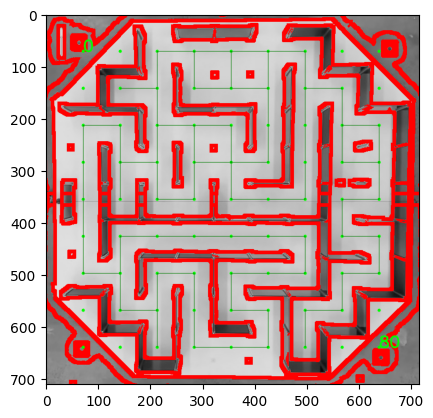

In [118]:
bfs_image = colour_image
bfs_graph = Graph()

# If you want the whole image’s side-length (in pixels):
h, w = bfs_image.shape[:2]     # bfs_image must be a NumPy array
side_length = min(h, w) # if it’s square this equals both
print(side_length)

# If you want the cropped/maze ROI’s side-length:
side_length = min(cropped.shape[:2])
print(side_length)

# side_length = 1180
gap = side_length/(bfs_n + 1)
width = 1
radius = 3
id = 0;

# Adding Nodes
for i in range(1, bfs_n + 1):
    y = i*gap
    for j in range(1, bfs_n + 1):
        x = j*gap
        bfs_graph.add_node(id, x, y)
        id+=1
        
nodes = bfs_graph.get_nodes()

# Adding Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
    
    if (j % bfs_n) != (bfs_n - 1):
        if path_clear(bfs_image, x, y, right, y + 1):
            id2 = j + 1
            bfs_graph.add_edge(j, id2, 1)

    if j < id - bfs_n:
        if path_clear(bfs_image, x, y, x + 1, down):
            id2 = j + bfs_n
            bfs_graph.add_edge(j, id2, 1)
    
    # Draw Nodes
    cv2.circle(bfs_image,(int(x),int(y)), 3, (0,255,0), -1)

# Draw Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
        
    for edge in bfs_graph.edges[node.id]:
        partner_id = edge[0]
        partner_node = bfs_graph.nodes[partner_id]
        
        cv2.line(bfs_image,(int(x), int(y)),(int(partner_node.x), int(partner_node.y)),(0, 125, 0), 1)


font = cv2.FONT_HERSHEY_SIMPLEX

first_node = bfs_graph.nodes[0]
cv2.putText(bfs_image,str(first_node.id),(int(first_node.x),int(first_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

last_node = bfs_graph.nodes[id - 1]
cv2.putText(bfs_image,str(last_node.id),(int(last_node.x),int(last_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

# Display Resulting Image
plt.imshow(bfs_image)
plt.show()

710
710


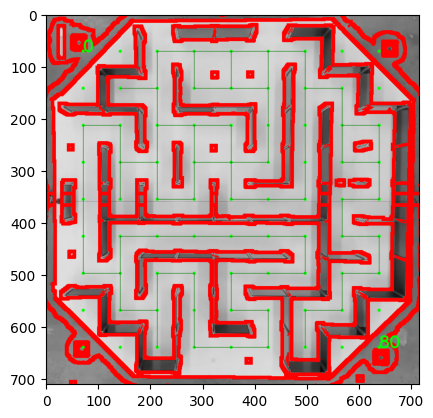

In [119]:
bfs_image = colour_image
bfs_graph = Graph()

# If you want the whole image’s side-length (in pixels):
h, w = bfs_image.shape[:2]     # bfs_image must be a NumPy array
side_length = min(h, w) # if it’s square this equals both
print(side_length)

# If you want the cropped/maze ROI’s side-length:
side_length = min(cropped.shape[:2])
print(side_length)

# side_length = 1180
gap = side_length/(bfs_n + 1)
width = 1
radius = 3
id = 0;

# Adding Nodes
for i in range(1, bfs_n + 1):
    y = i*gap
    for j in range(1, bfs_n + 1):
        x = j*gap
        bfs_graph.add_node(id, x, y)
        id+=1
        
nodes = bfs_graph.get_nodes()

# Adding Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
    
    if (j % bfs_n) != (bfs_n - 1):
        if path_clear(bfs_image, x, y, right, y + 1):
            id2 = j + 1
            bfs_graph.add_edge(j, id2, 1)

    if j < id - bfs_n:
        if path_clear(bfs_image, x, y, x + 1, down):
            id2 = j + bfs_n
            bfs_graph.add_edge(j, id2, 1)
    
    # Draw Nodes
    cv2.circle(bfs_image,(int(x),int(y)), 3, (0,255,0), -1)

# Draw Edges
for j in range(0, id):
    node = nodes[j]
    x = int(node.x)
    y = int(node.y)
    right = int(node.x + gap)
    down = int(node.y + gap)
        
    for edge in bfs_graph.edges[node.id]:
        partner_id = edge[0]
        partner_node = bfs_graph.nodes[partner_id]
        
        cv2.line(bfs_image,(int(x), int(y)),(int(partner_node.x), int(partner_node.y)),(0, 125, 0), 1)


font = cv2.FONT_HERSHEY_SIMPLEX

first_node = bfs_graph.nodes[0]
cv2.putText(bfs_image,str(first_node.id),(int(first_node.x),int(first_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

last_node = bfs_graph.nodes[id - 1]
cv2.putText(bfs_image,str(last_node.id),(int(last_node.x),int(last_node.y)),font,1,(0,255,0),2,cv2.LINE_AA)

# Save a copy BEFORE erasing so we can detect crossings
pre_erase = binary_obstacles.copy()

# Hard erase the centered band
binary_obstacles[y1:y2+1, :] = 0

# --- Reconnect vertical walls that cross the band ---
# Look a small window above and below; if a column has wall in both, restore that column through the band.
k = max(2, int(0.01 * h))  # vertical window ~1% of image height (tweak 0.005–0.02)

y_top_a = max(0, y1 - k)
y_top_b = y1
y_bot_a = y2 + 1
y_bot_b = min(h, y2 + 1 + k)

above = pre_erase[y_top_a:y_top_b, :]            # window just above the band
below = pre_erase[y_bot_a:y_bot_b, :]            # window just below the band

# Require at least ~50% of the window to be wall in that column (robust to noise)
need_above = (above == 255).sum(axis=0) >= max(1, int(0.5 * (y_top_b - y_top_a)))
need_below = (below == 255).sum(axis=0) >= max(1, int(0.5 * (y_bot_b - y_bot_a)))

cols_to_restore = np.where(need_above & need_below)[0]

# Restore vertical columns through the erased band
if cols_to_restore.size:
    binary_obstacles[y1:y2+1, cols_to_restore] = 255
    # optional: thicken a hair to ensure continuity after later morphology
    # binary_obstacles[y1:y2+1, np.clip(cols_to_restore[:,None] + np.array([-1,0,1]), 0, w-1)] = 255
    
# Display Resulting Image
plt.imshow(bfs_image)
plt.show()

In [120]:
# Task 3.2 (5 marks): Implement BFS

# Returns an array of nodes in order of which nodes are visited next.
# ie. [0, 10, 20, 30, 40, 50, 60, 70, 71, 72, 73, 74, 75, 76, 77, 78, 88, 98, 99]

def bfs(graph, start_node_id, end_node_id):
    
    visited = []
    Q = [start_node_id]
    parent = {}
    path = []
    
    while Q:

        current = Q.pop(0)
        visited.append(current)
        
        # Find all the connected nodes and add to Q
        for partner in graph.edges[current]:
            partner_id = partner[0]
            
            if partner_id not in visited and partner_id not in Q:
                # Make the current the parent to the partners
                parent[partner_id] = current
                Q.append(partner_id)
    
    current = end_node_id
    
    # Create the path by going backwards to the parent
    while True:
        path.append(current)
        if current == start_node_id:
            break
        current = parent[current]
    
    # Reverse to go in forwards direction
    path.reverse()
    return path

Path: [68, 77, 76, 75, 66, 57, 56, 65, 64, 55, 54, 45, 36, 27, 18, 19, 28, 29, 20, 11, 2, 3, 4, 5, 6, 15, 16, 25]


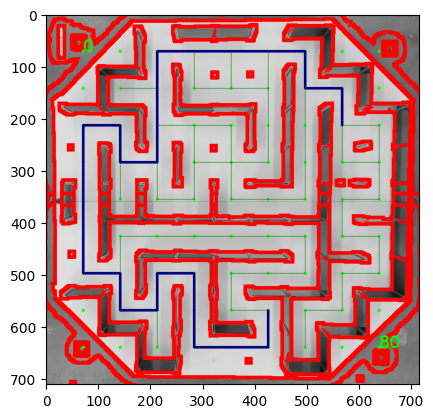

In [121]:
# Task 3.2: Implement BFS continued

# Run BFS and display the output
path = bfs(bfs_graph,bfs_start_node,bfs_end_node)

for i in range(len(path)):
    
    current_x = int(bfs_graph.nodes[path[i]].x)
    current_y = int(bfs_graph.nodes[path[i]].y)
    if i + 1 < len(path):
        next_x = int(bfs_graph.nodes[path[i + 1]].x)
        next_y = int(bfs_graph.nodes[path[i + 1]].y)
        cv2.line(bfs_image,(current_x, current_y),(next_x, next_y),(0, 0, 125), 3)

# Display the resulting image
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()

RRFRFFRFFLFLFRFRFLFRFFFFRFRFLFLFFFRFFFFRFLFRF
['R', 'R', 'F', 'R', 'F', 'F', 'R', 'F', 'F', 'L', 'F', 'L', 'F', 'R', 'F', 'R', 'F', 'L', 'F', 'R', 'F', 'F', 'F', 'F', 'R', 'F', 'R', 'F', 'L', 'F', 'L', 'F', 'F', 'F', 'R', 'F', 'F', 'F', 'F', 'R', 'F', 'L', 'F', 'R', 'F']
Path: [68, 77, 76, 75, 66, 57, 56, 65, 64, 55, 54, 45, 36, 27, 18, 19, 28, 29, 20, 11, 2, 3, 4, 5, 6, 15, 16, 25]


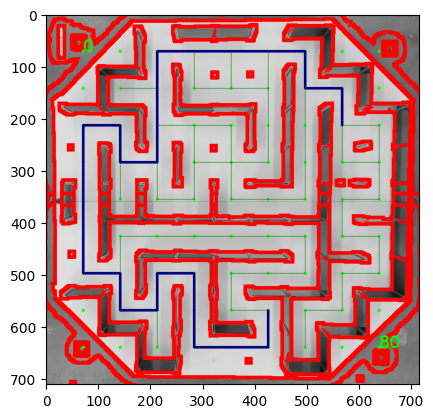

Start → row 7, col 5, dir N, node 68
Goal  → row 2,  col 7,  dir S,  node 25


In [122]:

# def generate_robot_commands(graph, path, start_dir: str, goal_dir: str):
#     """
#     Minimal path -> L/R/F with start & goal orientations.
#     - 4-connected grid; image coords (x right, y down).
#     - start_dir / goal_dir in {'N','E','S','W'} (case-insensitive).
#     Returns: (command_string, command_list)
#     """
#     # Clockwise canonical ordering
#     DIRS = [(1,0), (0,1), (-1,0), (0,-1)]  # E, S, W, N
#     CHAR2IDX = {'E':0, 'S':1, 'W':2, 'N':3}

#     def unit_step(a, b, eps=1e-6):
#         dx = b.x - a.x; dy = b.y - a.y
#         dx = 0 if abs(dx) <= eps else (1 if dx > 0 else -1)
#         dy = 0 if abs(dy) <= eps else (1 if dy > 0 else -1)
#         step = (dx, dy)
#         if step not in DIRS and step != (0,0):
#             raise ValueError(f"Non-cardinal step in path: {step}")
#         return step

#     def turn_seq(cur_idx, tgt_idx):
#         diff = (tgt_idx - cur_idx) % 4
#         if diff == 0: return []
#         if diff == 1: return ['R']
#         if diff == 2: return ['R','R']
#         return ['L']  # diff == 3

#     # Build move directions (skip zero-length hops)
#     moves = []
#     for i in range(max(0, len(path)-1)):
#         a = graph.nodes[path[i]]
#         b = graph.nodes[path[i+1]]
#         s = unit_step(a, b)
#         if s != (0,0):
#             moves.append(s)

#     s_idx = CHAR2IDX[start_dir.upper()]
#     g_idx = CHAR2IDX[goal_dir.upper()]

#     cmds = []
#     cmd_str = ""

#     if not moves:
#         # No translation; just rotate from start_dir to goal_dir
#         t = turn_seq(s_idx, g_idx)
#         cmds.extend(t); cmd_str += ''.join(t)
#         return cmd_str, cmds

#     # 1) Rotate from start_dir to first move direction
#     first_idx = DIRS.index(moves[0])
#     t0 = turn_seq(s_idx, first_idx)
#     if t0:
#         cmds.extend(t0); cmd_str += ''.join(t0)

#     # 2) Execute path
#     cur_idx = first_idx
#     cmds.append('F'); cmd_str += 'F'
#     for s in moves[1:]:
#         nxt_idx = DIRS.index(s)
#         diff = (nxt_idx - cur_idx) % 4
#         if diff == 0:
#             cmds.append('F'); cmd_str += 'F'
#         elif diff == 1:
#             cmds.extend(['R','F']); cmd_str += 'RF'; cur_idx = nxt_idx
#         elif diff == 2:
#             cmds.extend(['R','R','F']); cmd_str += 'RRF'; cur_idx = nxt_idx
#         else:  # diff == 3
#             cmds.extend(['L','F']); cmd_str += 'LF'; cur_idx = nxt_idx

#     # 3) Rotate from final facing to goal_dir
#     t1 = turn_seq(cur_idx, g_idx)
#     if t1:
#         cmds.extend(t1); cmd_str += ''.join(t1)

#     return cmd_str, cmds

def generate_robot_commands(graph, path, start_dir: str, goal_dir: str):
    """
    Minimal path -> L/R/F with ONLY start orientation respected.
    No turn at the goal, and no turn-only behavior if path has no moves.
    """
    # Clockwise canonical ordering
    DIRS = [(1,0), (0,1), (-1,0), (0,-1)]  # E, S, W, N
    CHAR2IDX = {'E':0, 'S':1, 'W':2, 'N':3}

    def unit_step(a, b, eps=1e-6):
        dx = b.x - a.x; dy = b.y - a.y
        dx = 0 if abs(dx) <= eps else (1 if dx > 0 else -1)
        dy = 0 if abs(dy) <= eps else (1 if dy > 0 else -1)
        step = (dx, dy)
        if step not in DIRS and step != (0,0):
            raise ValueError(f"Non-cardinal step in path: {step}")
        return step

    def turn_seq(cur_idx, tgt_idx):
        diff = (tgt_idx - cur_idx) % 4
        if diff == 0: return []
        if diff == 1: return ['R']
        if diff == 2: return ['R','R']
        return ['L']  # diff == 3

    # Build move directions (skip zero-length hops)
    moves = []
    for i in range(len(path)-1):
        a = graph.nodes[path[i]]
        b = graph.nodes[path[i+1]]
        s = unit_step(a, b)
        if s != (0,0):
            moves.append(s)

    # If there are no moves, do nothing (no orientation change)
    if not moves:
        return "", []

    # Respect start orientation ONLY
    s_idx = CHAR2IDX[start_dir.upper()]
    cmds, cmd_str = [], ""

    # 1) Rotate from start_dir to first move direction
    first_idx = DIRS.index(moves[0])
    t0 = turn_seq(s_idx, first_idx)
    if t0:
        cmds.extend(t0); cmd_str += ''.join(t0)

    # 2) Execute path (no final orientation to goal_dir)
    cur_idx = first_idx
    cmds.append('F'); cmd_str += 'F'
    for s in moves[1:]:
        nxt_idx = DIRS.index(s)
        diff = (nxt_idx - cur_idx) % 4
        if diff == 0:
            cmds.append('F'); cmd_str += 'F'
        elif diff == 1:
            cmds.extend(['R','F']); cmd_str += 'RF'; cur_idx = nxt_idx
        elif diff == 2:
            cmds.extend(['R','R','F']); cmd_str += 'RRF'; cur_idx = nxt_idx
        else:  # diff == 3
            cmds.extend(['L','F']); cmd_str += 'LF'; cur_idx = nxt_idx

    return cmd_str, cmds
cmd_str, cmds = generate_robot_commands(bfs_graph, path, start_dir, goal_dir)
print(cmd_str)
print(cmds)
print(f"Path: {path}")
plt.imshow(bfs_image)
plt.show()
start_str = f"Start → row {start_row_idx}, col {start_col_idx}, dir {start_dir}, node {bfs_start_node}"
goal_str  = f"Goal  → row {goal_row_idx},  col {goal_col_idx},  dir {goal_dir},  node {bfs_end_node}"

print(start_str)
print(goal_str)